# Previsão de Receita (pagamento das apólices)

## Tratamento de dados e EDA

In [2]:

#Importando as bibliotecas necessárias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Coletando os dados 
# df_venda = pd.read_excel('case_analista_de_inteligncia_e_performance_-_2023.xlsx', sheet_name='venda')
df_receita = pd.read_excel('case_analista_de_inteligncia_e_performance_-_2023.xlsx', sheet_name='receita')

In [4]:
df_receita


,ano,mes,seguradora,vendedor,tot_apolices,receita
0,2019,1,72,58,1,65.300
1,2019,1,72,57,4,1360.235
2,2019,1,72,56,3,276.490
3,2019,1,72,47,2,-1707.095
4,2019,1,72,38,3,1080.745
...,...,...,...,...,...,...
1075,2020,6,72,14,1,98.935
1076,2020,6,72,13,3,3244.695
1077,2020,6,72,12,3,267.235
1078,2020,6,72,9,12,2157.955


In [5]:
df_receita.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ano           1080 non-null   int64  
 1   mes           1080 non-null   int64  
 2   seguradora    1080 non-null   int64  
 3   vendedor      1080 non-null   int64  
 4   tot_apolices  1080 non-null   int64  
 5   receita       1080 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 50.8 KB


### Verificando a distribuição da coluna receita

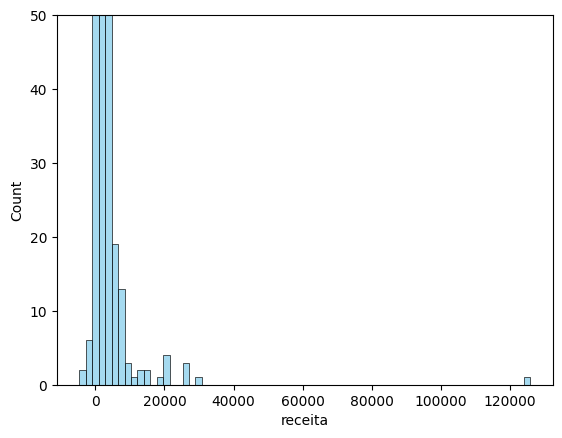

In [6]:
sns.histplot(df_receita.receita, bins=70, kde=False, color='skyblue')
#Limite o y para 50 pois não estava dando para ver as frequências dos outros valores
plt.ylim(0, 50)
plt.show()

Como pode ser visto há um possível outlier acima de 120.000 de receita

In [17]:
#Removendo valores negativos pois são cancelamentos
df_receita = df_receita.query('receita >= 0')
df_receita


,ano,mes,seguradora,vendedor,tot_apolices,receita
0,2019,1,72,58,1,65.300
1,2019,1,72,57,4,1360.235
2,2019,1,72,56,3,276.490
4,2019,1,72,38,3,1080.745
5,2019,1,72,35,2,446.095
...,...,...,...,...,...,...
1075,2020,6,72,14,1,98.935
1076,2020,6,72,13,3,3244.695
1077,2020,6,72,12,3,267.235
1078,2020,6,72,9,12,2157.955


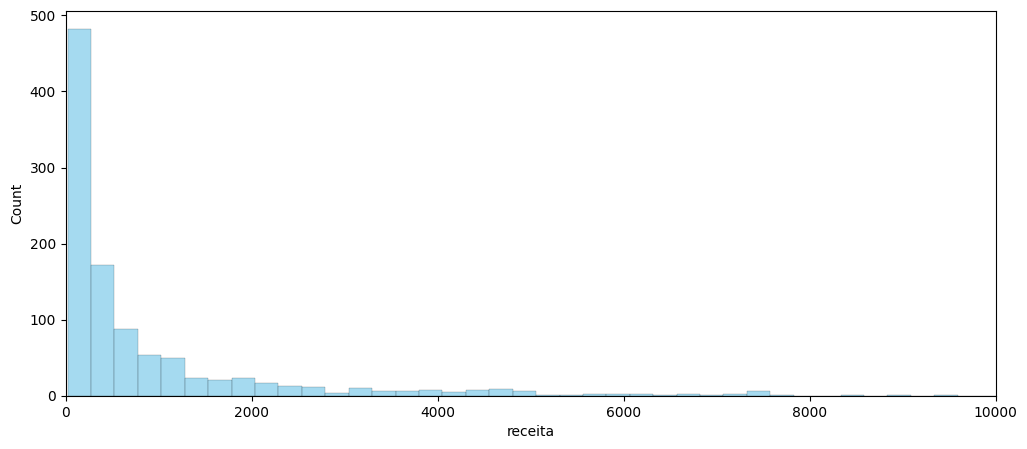

In [15]:
#Verificando a distribuição após remover os valores cancelados
plt.figure(figsize=(12, 5))
sns.histplot(df_receita.receita, bins=500, kde=False, color='skyblue')
#limitei o x para não aparecer o possível outlier
plt.xlim(0,10000)
plt.show()